# Прогноз количества заказов такси

Компания «Зеленоглазое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# 2. Анализ

In [4]:
data.index.is_monotonic

True

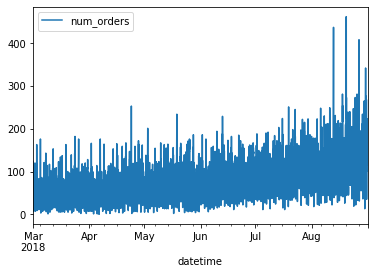

In [5]:
data.plot()

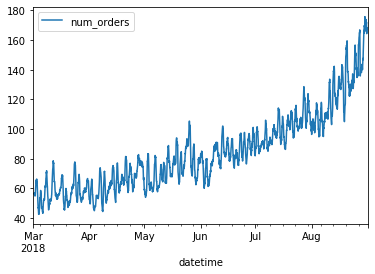

In [6]:
decomposed = seasonal_decompose(data)
decomposed.trend.plot(ax=plt.gca())
plt.show()

### Для проверки на сезонность наша выборка слишком мала. Проверили ее на наличие трендов. Увидили увеличение спроса от марта к августу.

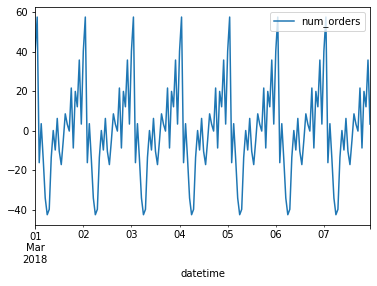

In [17]:
decomposed = seasonal_decompose(data['2018-03-01':'2018-03-07'])
decomposed.seasonal.plot(ax=plt.gca())

### Добавила график внутрисуточной сезонности. Оказалось, что в течении для самый низкий спрос около 7:00, а самый высокий около полуночи. 

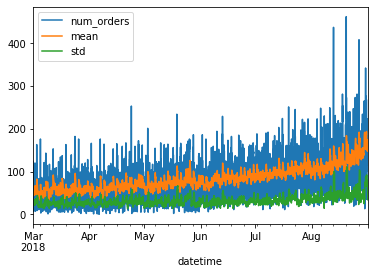

In [63]:
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()
data.plot()

### Построили график скользящего стандартного отклонения. 

# 3. Обучение

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

make_features(data, 168, 7)
data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,167.428571
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,167.428571
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,165.714286


In [21]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

## Обучим 3 разные модели: Линейную регрессию, RandomForestRegressor и CatBoostRegressor. Для последних двух подберем гиперпараметры с помощью GridSearchCV. 

In [22]:
model_1 = LinearRegression()
model_1.fit(train_features, train_target)
predictions_1 = model_1.predict(test_features)

In [23]:
model_2 = RandomForestRegressor(random_state=12345)
parameters_2 = {'max_depth':range(5,56,10), 'min_samples_split':[2,3,4]}
gread_search_2 = GridSearchCV(
    estimator = model_2, param_grid = parameters_2, scoring= 'neg_mean_squared_error', refit='neg_mean_squared_error', cv=5)

In [24]:
GS_model_2 = gread_search_2.fit(train_features, train_target)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [25]:
print('Среднее rmse =', (-GS_model_2.cv_results_['mean_test_score'].mean())**0.5)
print('Лучшие параметры модели: ',GS_model_2.best_params_)

Среднее rmse = 23.459178592290186
Лучшие параметры модели:  {'max_depth': 15, 'min_samples_split': 4}


In [26]:
model_3 = CatBoostRegressor(random_state=12345)
parameters_3 = {'iterations':[10, 20], 'depth':[5,10]}
gread_search_3 = GridSearchCV(
    estimator = model_3, param_grid = parameters_3, scoring= 'neg_mean_squared_error', refit='neg_mean_squared_error', cv=5)

In [27]:
GS_model_3 = gread_search_3.fit(train_features, train_target)

0:	learn: 38.2198818	total: 58.9ms	remaining: 530ms
1:	learn: 37.6383979	total: 102ms	remaining: 409ms
2:	learn: 37.1038251	total: 198ms	remaining: 462ms
3:	learn: 36.5458922	total: 211ms	remaining: 317ms
4:	learn: 36.0082000	total: 305ms	remaining: 305ms
5:	learn: 35.5027787	total: 399ms	remaining: 266ms
6:	learn: 34.9915704	total: 493ms	remaining: 211ms
7:	learn: 34.5448916	total: 503ms	remaining: 126ms
8:	learn: 34.0958617	total: 598ms	remaining: 66.4ms
9:	learn: 33.6535141	total: 693ms	remaining: 0us
0:	learn: 38.7872869	total: 9.89ms	remaining: 89.1ms
1:	learn: 38.1845690	total: 81.7ms	remaining: 327ms
2:	learn: 37.6121614	total: 177ms	remaining: 414ms
3:	learn: 37.0346780	total: 274ms	remaining: 411ms
4:	learn: 36.4578304	total: 284ms	remaining: 284ms
5:	learn: 35.9401215	total: 380ms	remaining: 253ms
6:	learn: 35.4089813	total: 478ms	remaining: 205ms
7:	learn: 34.9228243	total: 574ms	remaining: 144ms
8:	learn: 34.4778415	total: 670ms	remaining: 74.5ms
9:	learn: 34.0156092	total:

In [28]:
print('Среднее rmse =', (-GS_model_3.cv_results_['mean_test_score'].mean())**0.5)
print('Лучшие параметры модели: ',GS_model_3.best_params_)

Среднее rmse = 33.707084110647244
Лучшие параметры модели:  {'depth': 5, 'iterations': 20}


# 4. Тестирование

In [29]:
rmse_1 = mean_squared_error(test_target, predictions_1)**0.5
print('RMSE линейной регрессии =', rmse_1 )

RMSE линейной регрессии = 34.521221373169396


In [31]:
model_2 = RandomForestRegressor(max_depth= 15, min_samples_split= 4, random_state=12345)
model_2.fit(train_features, train_target)
predictions_2 = model_2.predict(test_features)
rmse_2 = mean_squared_error(test_target, predictions_2)**0.5
print('RMSE RandomForestRegressor =',rmse_2)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE RandomForestRegressor = 40.59769303116546


In [32]:
model_3 = CatBoostRegressor(depth=10, iterations=20, random_state=12345)
model_3.fit(train_features, train_target)
predictions_3 = model_3.predict(test_features)
rmse_3 = mean_squared_error(test_target, predictions_3)**0.5
print('RMSE CatBoostRegressor =',rmse_3)

0:	learn: 38.0065328	total: 831ms	remaining: 15.8s
1:	learn: 37.4259211	total: 1.73s	remaining: 15.6s
2:	learn: 36.8373751	total: 2.63s	remaining: 14.9s
3:	learn: 36.2713164	total: 3.53s	remaining: 14.1s
4:	learn: 35.7310648	total: 4.43s	remaining: 13.3s
5:	learn: 35.1711881	total: 5.33s	remaining: 12.4s
6:	learn: 34.6640036	total: 6.23s	remaining: 11.6s
7:	learn: 34.2001557	total: 7.13s	remaining: 10.7s
8:	learn: 33.7303846	total: 8.11s	remaining: 9.92s
9:	learn: 33.2308431	total: 9.01s	remaining: 9.01s
10:	learn: 32.7566781	total: 9.91s	remaining: 8.11s
11:	learn: 32.3349025	total: 10.8s	remaining: 7.21s
12:	learn: 31.8794081	total: 11.6s	remaining: 6.26s
13:	learn: 31.4171374	total: 12.6s	remaining: 5.4s
14:	learn: 30.9712487	total: 13.4s	remaining: 4.47s
15:	learn: 30.5576243	total: 14.4s	remaining: 3.6s
16:	learn: 30.1568410	total: 15.3s	remaining: 2.7s
17:	learn: 29.7649764	total: 16.1s	remaining: 1.79s
18:	learn: 29.4090576	total: 17s	remaining: 896ms
19:	learn: 29.0660257	total

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: test_target, Length: 442, dtype: int64


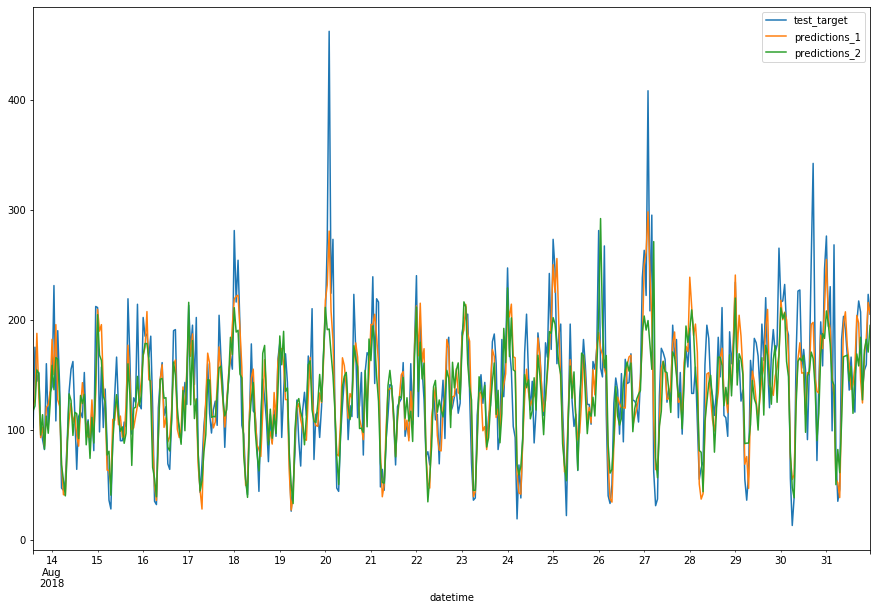

In [63]:
test_target = test_target.rename('test_target')
test_target.plot(figsize=(15,10), legend=True)
print(test_target)
pred_1 = pd.Series(predictions_1, index=test_target.index, name='predictions_1')
pred_1.plot(ax=plt.gca(), legend=True)
pred_2 = pd.Series(predictions_2, index=test_target.index, name='predictions_2')
pred_2.plot(ax=plt.gca(), legend=True)

### Построили график, на котором существуют фактические значения (test_target), предсказания линейной регресии (predictions_1) и предсказания RandomForestRegressor(predictions_2).

## Вывод: для каждой из 3 моделей вычислили RMSE на тестовой выборке. Для линейной регресии и RandomForestRegressor RMSE получилось <48, а для CatBoostRegressor больше.